eval_func - функционал качества J

In [1]:
import operator
import math
import random

import numpy as np
import scipy as sp
from deap import algorithms, base, creator, tools, gp

In [2]:
# новое деление
def division_operator(numerator, denominator):
    if denominator == 0:
        return 1

    return numerator / denominator 

In [17]:
#Параметры
xf = np.array([0, 0, 0])
X_init = np.array([10, 10, 0])
epsilon = 0.01
t_max = 2.
r = np.array([2, 2])
x_limit = np.array([[7.5, 7.5],[2.5, 2.5]])

# **Вся сложность тут**

Если делать по книге, то нужно будет отдельно реализовать функции x1(t), x2(t), x3(t), от них и зависит u.
x1, x2, x3 в одной функции

In [18]:
def model_coord(t, inits, individual, done = 1):
    x1_np = np.array([inits[0]])
    x2_np = np.array([inits[1]])
    x3_np = np.array([inits[2]])
    u = toolbox.compile(expr=individual)
    for dt in np.arange(0, t, 0.01):
        u_t = u(round(x1_np[-1],10), round(x2_np[-1], 10), round(x3_np[-1],10))
        if math.fabs(u_t) < 1:
            x3_np = np.append(x3_np, x3_np[-1] + 10*math.tan(u_t)*0.01)
        if u_t >= 1:
            x3_np = np.append(x3_np, x3_np[-1] + 10*math.tan(1.)*0.01)
        if u_t <= -1:
            x3_np = np.append(x3_np, x3_np[-1] + 10*math.tan(-1.)*0.01)
        x1_np = np.append(x1_np, x1_np[-1] + 10*math.cos(x3_np[-1]) * 0.01)
        x2_np = np.append(x2_np, x2_np[-1] + 10*math.sin(x3_np[-1])*0.01)
    return x1_np, x2_np, x3_np
    

**Вычисление ТОЛЬКО при одном t, а не на всем промежутке**

In [19]:
#Фазовые ограничения
def g(inits): 
    x1 = inits[0]
    x2 = inits[1]
    return r-sp.sqrt((x1-x_limit[:,0])**2+(x2-x_limit[:,1])**2) #возвращает массив len = количество ограничений

In [20]:
def theta(g):
    t = np.array([])
    for element in g:
        if (element>0):
            t = np.append(t,1)
        else:
            t = np.append(t,0)
    return t #возвращает массив len = количество ограничений

In [21]:
def J(inits, individual): #J(u(x))
    s_results, t, coords = s(inits, individual)
    distance = x_xf(coords)
    return s_results*2+t+distance,

In [22]:
def s(x_init, individual):
    iter_max = t_max*100-1
    dt = 0.01
    i = 0
    s_fin = 0
    tf = 0
    x1, x2, x3 = model_coord(t_max, x_init, individual) #element вместо x_init
    while i < iter_max and x_xf(np.array([x1[i], x2[i], x3[i]]))>=epsilon:
        limits = g(np.array([x1[i], x2[i]]))
        s_fin = s_fin + sum(theta(limits)*limits)
        tf += dt
        i += 1
    s_all = s_fin*dt
    return s_all, tf, np.array([x1[-1], x2[-1], x3[-1]]) #возвращается массив s для всех начальных условий, а также массив времен окончания движения

In [23]:
def x_xf(x):
    return np.sqrt(sum((x-xf)**2)) #возвращает только одно значение ошибки для конкретных начальных условий

In [24]:
# Define the evaluation function
def eval_func(individual, points):
    return J(points, individual)

In [28]:
# Function to create the toolbox
def create_toolbox():
    pset = gp.PrimitiveSet("MAIN", 3)
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(division_operator, 2)
    pset.addPrimitive(operator.neg, 1)
    pset.addPrimitive(math.cos, 1)
    pset.addPrimitive(math.sin, 1)
    pset.addPrimitive(math.fabs, 1)

    pset.addEphemeralConstant("rand1", lambda: random.randint(-5,5))

    pset.renameArguments(ARG0='x')
    pset.renameArguments(ARG1="y")
    pset.renameArguments(ARG2="z")

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=7)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)
    toolbox.register("evaluate", eval_func, points=X_init)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=7)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

    return toolbox


In [29]:
toolbox = create_toolbox()
random.seed(7)

population = toolbox.population(n=2000)
hall_of_fame = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda x: x.fitness.values)
stats_size = tools.Statistics(len)

mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

C:\Users\irisc\anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\irisc\anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [30]:
probab_crossover = 0.4
probab_mutate = 0.7
num_generations = 150

In [31]:
%%time
population, log = algorithms.eaSimple(population, toolbox, 
                                      probab_crossover, probab_mutate, num_generations, 
                                      stats=mstats, halloffame=hall_of_fame, verbose=True)

C:\Users\irisc\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std    	avg    	gen	max	min	nevals	std    
0  	2000  	30.5479	0  	36.1514	3.48429	2000  	7.04968	12.9015	0  	112	2  	2000  	15.2799
1  	1636  	27.2744	1  	36.1514	3.48429	1636  	7.8463 	23.7485	1  	162	1  	1636  	24.1817
2  	1647  	25.0833	2  	36.1514	4.21178	1647  	8.0675 	34.0525	2  	209	1  	1647  	30.0413
3  	1648  	23.2602	3  	36.1514	3.45757	1648  	8.43062	43.4795	3  	209	1  	1648  	33.8313
4  	1661  	21.078 	4  	36.1514	3.17598	1661  	8.64439	52.5555	4  	215	1  	1661  	37.6926
5  	1621  	18.7898	5  	36.1514	3.17598	1621  	8.72032	62.935 	5  	246	1  	1621  	41.7032
6  	1652  	16.909 	6  	36.1514	3.17598	1652  	8.9801 	74.8375	6  	252	1  	1652  	45.3401
7  	1640  	14.7954	7  	36.1514	3.17598	1640  	8.78717	88.1555	7  	253	1  	

89 	1657  	4.80415	89 	36.1514	1.99693	1657  	7.15328	290.709	89 	456	3  	1657  	46.3598
90 	1601  	4.56375	90 	36.1514	1.99693	1601  	6.84001	290.558	90 	425	1  	1601  	47.0306
91 	1654  	4.80237	91 	36.1514	1.99693	1654  	7.2961 	293.264	91 	395	3  	1654  	41.2866
92 	1655  	4.70151	92 	36.1514	1.99693	1655  	7.1223 	293.096	92 	419	4  	1655  	42.1684
93 	1643  	4.54121	93 	36.1514	1.99597	1643  	6.70115	294.99 	93 	458	2  	1643  	40.511 
94 	1635  	4.66137	94 	36.1514	1.99597	1635  	6.99377	294.94 	94 	441	2  	1635  	41.1467
95 	1685  	4.95059	95 	36.1514	1.99597	1685  	7.40327	295.762	95 	394	9  	1685  	40.2689
96 	1673  	4.7336 	96 	36.1514	1.99597	1673  	7.1808 	297.865	96 	425	1  	1673  	42.5663
97 	1623  	4.60057	97 	36.1514	1.99597	1623  	6.91035	298.313	97 	418	1  	1623  	41.8584
98 	1637  	4.73411	98 	36.1514	1.99597	1637  	7.08432	297.594	98 	455	1  	1637  	47.0366
99 	1611  	4.40614	99 	36.1514	1.99597	1611  	6.54009	299.156	99 	455	1  	1611  	41.7373
100	1632  	4.62001	10

In [34]:
x, y, z = model_coord(2., np.array([10, 10, 0]), hall_of_fame[0])

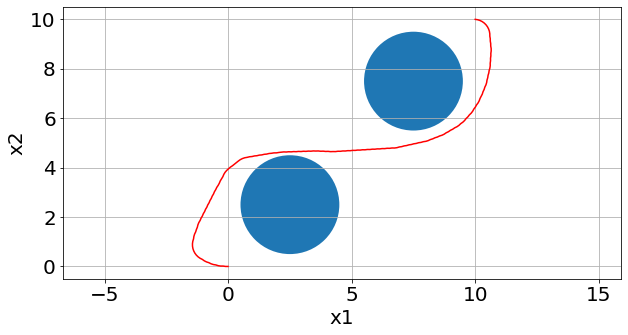

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
fig = plt.gcf()
ax = fig.gca()
plt.plot(x,y,color = 'red')
plt.axis('equal')
ax.grid()
circle1 = plt.Circle((7.5, 7.5), radius = 2)
circle2 = plt.Circle((2.5, 2.5), radius = 2)
ax.add_artist(circle1)
ax.add_artist(circle2)
plt.xlabel("x1", fontsize = '20')
plt.ylabel("x2", fontsize = '20')
plt.tick_params(axis='both', which='major', labelsize=20)

In [36]:
print(hall_of_fame[0])

sub(add(cos(y), add(2, y)), sub(sub(sin(sin(sin(x))), neg(fabs(add(add(sin(fabs(division_operator(fabs(add(neg(x), sub(x, x))), neg(sub(sin(y), division_operator(z, y)))))), sin(cos(mul(add(fabs(cos(neg(sub(add(x, x), division_operator(z, z))))), sub(sin(fabs(division_operator(division_operator(x, x), sub(y, -4)))), division_operator(division_operator(sin(x), add(sub(x, x), neg(y))), sin(fabs(mul(-3, y)))))), mul(3, division_operator(neg(neg(neg(sin(x)))), division_operator(add(add(sin(3), neg(-1)), sub(cos(z), neg(z))), division_operator(sin(neg(y)), cos(sub(5, add(2, -3))))))))))), mul(x, add(division_operator(add(add(cos(neg(mul(division_operator(sub(y, x), mul(-5, x)), sin(fabs(x))))), mul(sub(sin(mul(sub(-2, z), mul(z, z))), sin(cos(division_operator(-1, y)))), sub(sub(sub(cos(-2), sub(x, x)), sub(fabs(y), sin(3))), mul(neg(cos(z)), cos(x))))), -5), sub(sin(z), sub(x, z))), x)))))), mul(sub(mul(-5, 3), add(mul(fabs(add(y, sub(cos(fabs(x)), sin(division_operator(neg(mul(mul(add(z, 

In [40]:
l = open('log.txt', 'w')

In [41]:
l.write(str(log))
l.close()

In [42]:
h = open('hall_of_fame.txt', 'w')

In [43]:
h.write(str(hall_of_fame[0]))

1650

In [44]:
h.close()

In [207]:
x1 = open('x.txt', 'w')
X = np.zeros((len(x),1))
for i in range(len(x)):
    X[i][0] = x[i]
x1.write(str(X))
x1.close()

In [208]:
y1 = open('y.txt', 'w')
Y = np.zeros((len(x),1))
for i in range(len(x)):
    Y[i][0] = y[i]
y1.write(str(Y))
y1.close()

In [209]:
z1 = open('z.txt', 'w')
Z = np.zeros((len(x),1))
for i in range(len(x)):
    Z[i][0] = z[i]
z1.write(str(Z))
z1.close()

In [210]:
u = toolbox.compile(expr=hall_of_fame[0])

In [211]:
U = np.zeros((len(x),1))
for i in range(len(x)):
    U[i][0] = u(x[i],y[i],z[i])

In [212]:
u1 = open('u.txt', 'w')
u1.write(str(U))
u1.close()

In [51]:
max(U)

array([930.66386668])

In [52]:
min(U)

array([-1295.3902681])